In [5]:
from netCDF4 import Dataset, MFDataset
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import pandas as pd

In [6]:
def create_df(data: xr.Dataset, year):
    data = data.to_dataframe().reset_index()
    lon_bounds, lat_bounds = [-25, 65], [35, 72]
    data = data[(data.lon > lon_bounds[0]) & (data.lon < lon_bounds[1]) & (data.lat > lat_bounds[0]) & (data.lat < lat_bounds[1])]

    df = pd.DataFrame(columns=['Latitude', 'Longitude', 'Emissions', 'Month', 'Year']) 
    df['Longitude'] = data['lon'][:]
    df['Latitude'] = data['lat'][:]
    df['Emissions'] = data['land'][:]
    df['Month'] = data['month'][:]
    df['Year'] = year

    return df

In [45]:
dd = xr.open_dataset(Path.cwd()/'data2/raw/odiac/odiac2022_1x1d_2015.nc')

In [46]:
dd['land']

<xarray.DataArray 'land' (month: 12, lat: 180, lon: 360)>
[777600 values with dtype=float32]
Coordinates:
  * lon      (lon) float64 -179.5 -178.5 -177.5 -176.5 ... 177.5 178.5 179.5
  * lat      (lat) float64 -89.5 -88.5 -87.5 -86.5 -85.5 ... 86.5 87.5 88.5 89.5
  * month    (month) int32 1 2 3 4 5 6 7 8 9 10 11 12
Attributes:
    units:       gC/m2/d
    long_name:   ffco2_emission
    definition:  CO2 emissions from fossil fuel combustion, cememt production...

In [7]:
def aggregate_data():
    pathlist = (Path.cwd()/'data2/raw/odiac/').glob('*.nc')
    big_df = pd.DataFrame(columns=['Latitude', 'Longitude', 'Emissions', 'Month', 'Year']) 
    for path in pathlist:   
        year = int(str(path)[-7:-3])   
        data = xr.open_dataset(path)
        try:
            df = create_df(data, year)
            big_df = pd.concat([big_df, df])
        except:
            continue   

    return big_df

In [8]:
agg = aggregate_data() 
agg

,Latitude,Longitude,Emissions,Month,Year
336300,35.5,-24.5,0.0,1,2016
336301,35.5,-24.5,0.0,2,2016
336302,35.5,-24.5,0.0,3,2016
336303,35.5,-24.5,0.0,4,2016
336304,35.5,-24.5,0.0,5,2016
...,...,...,...,...,...
528979,71.5,64.5,0.0,8,2015
528980,71.5,64.5,0.0,9,2015
528981,71.5,64.5,0.0,10,2015
528982,71.5,64.5,0.0,11,2015


In [9]:
agg.to_csv(Path.cwd()/'data2/clean/odiac_monthly.csv', index=False)

In [10]:
import geopandas as gpd
import geoplot as gplt
from shapely.geometry import Polygon, MultiPolygon, box
gdf = gpd.GeoDataFrame(
    agg, geometry=gpd.points_from_xy(x=agg.Longitude, y=agg.Latitude)
)

In [11]:
world_filepath = gpd.datasets.get_path('naturalearth_lowres')
world = gpd.read_file(world_filepath)
europe = gpd.clip(world, box(-25, 35, 65, 72))

In [12]:
gdf

,Latitude,Longitude,Emissions,Month,Year,geometry
336300,35.5,-24.5,0.0,1,2016,POINT (-24.50000 35.50000)
336301,35.5,-24.5,0.0,2,2016,POINT (-24.50000 35.50000)
336302,35.5,-24.5,0.0,3,2016,POINT (-24.50000 35.50000)
336303,35.5,-24.5,0.0,4,2016,POINT (-24.50000 35.50000)
336304,35.5,-24.5,0.0,5,2016,POINT (-24.50000 35.50000)
...,...,...,...,...,...,...
528979,71.5,64.5,0.0,8,2015,POINT (64.50000 71.50000)
528980,71.5,64.5,0.0,9,2015,POINT (64.50000 71.50000)
528981,71.5,64.5,0.0,10,2015,POINT (64.50000 71.50000)
528982,71.5,64.5,0.0,11,2015,POINT (64.50000 71.50000)


/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:


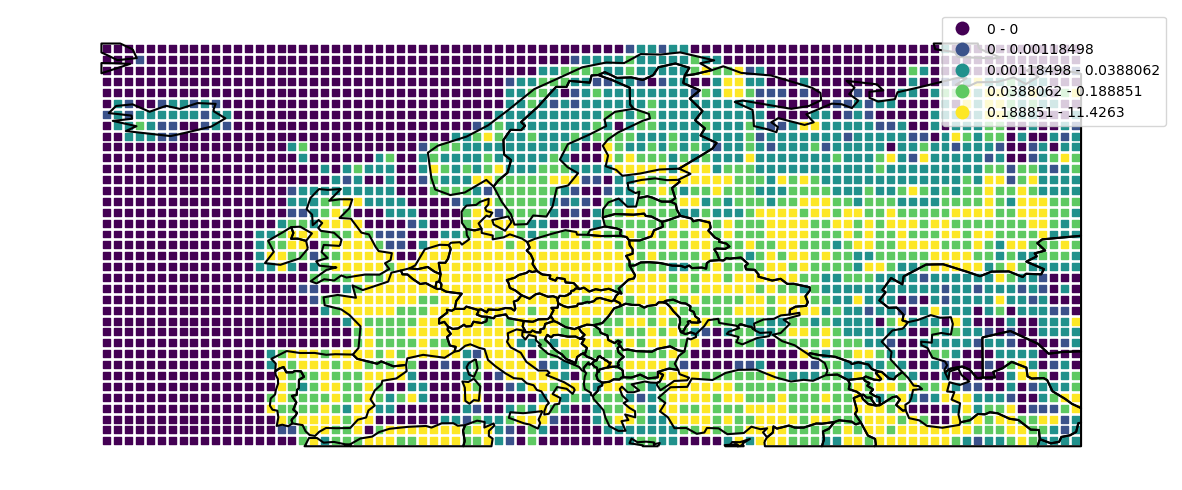

In [13]:
import mapclassify as mc

scheme = mc.Quantiles(gdf[(gdf.Year == 2019) & (gdf.Month == 5)]['Emissions'], k=5)

fig, ax = plt.subplots(figsize = (15,15))

europe.boundary.plot(figsize=(12,8),ax=ax, color='black')
# gplt.pointplot(
#     gdf[(gdf.Year == 2017) & (gdf.Month == 1)],
#     hue='xco2',
#     ax=ax
# )
gplt.pointplot(gdf[(gdf.Year == 2019) & (gdf.Month == 5)], hue='Emissions', cmap='viridis', ax=ax, scheme=scheme, legend=True, marker='s')

plt.show()

In [35]:
def plot_emission_map(gdf: gpd.GeoDataFrame, year: int, month: int, quantiles: int):
    fig_size = (12,5)
    fig, ax = plt.subplots(figsize = fig_size)
    europe.boundary.plot(
        figsize=fig_size,
        ax=ax,
        color='black'
    )
    gdf[(gdf.Year == year) & (gdf.Month == month)].plot(
        'Emissions', 
        ax=ax,
        scheme='quantiles', 
        k=quantiles, 
        figsize=fig_size,
        marker='s',
        markersize=40,
        legend=True, legend_kwds={'bbox_to_anchor': (1, 1)}
    )
    plt.axis('off')
    plt.show()

/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/geopandas/plotting.py:48: ShapelyDeprecationWarning: The 'type' attribute is deprecated, and will be removed in the future. You can use the 'geom_type' attribute instead.
  if geom is not None and geom.type.startswith(prefix) and not geom.is_empty:
/Users/timurkambachekov/opt/anaconda3/envs/geo_base/lib/python3.11/site-packages/mapclassify/classifiers.py:255: UserWarning: Not enough unique values in array to form 20 classes. Setting k to 14.
  warnings.warn(


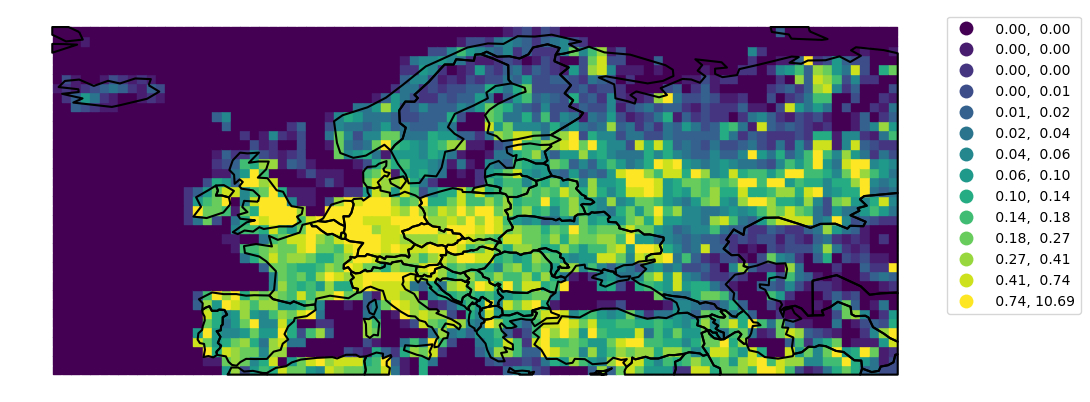

In [41]:
plot_emission_map(gdf, 2015, 5, 20)

In [16]:
gdf.explore()

AttributeError: 'GeoDataFrame' object has no attribute 'explore'